In [1]:
import pyvista as pv
import numpy as np
from typing import Any, Tuple
from importlib import reload
import multiprocessing
import ifcopenshell
import ifcopenshell.geom
import time
from functools import reduce
import open3d as o3d
from multiprocessing import Pool, cpu_count


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def open3d_block_by_element(ifc_file): 
    settings = ifcopenshell.geom.settings()
    settings.set(settings.USE_WORLD_COORDS, True)
    settings.set(settings.APPLY_DEFAULT_MATERIALS, True)
    iterator = ifcopenshell.geom.iterator(settings, ifc_file, multiprocessing.cpu_count())
    include_list = ["IfcWall", "IfcSlab", "IfcBeam", "IfcColumn", "IfcWallStandardCase", "IfcFoundation", "IfcRoof"]
    all_meshes = []
    element_information = {}
    ind = 0
    temp_dimension = 5.0
    if iterator.initialize():
        while True:
            shape = iterator.get()
            if shape.type in include_list:
                
                product = ifc_file.by_guid(shape.guid)

                faces = np.array(shape.geometry.faces)             
                verts = np.array(shape.geometry.verts).reshape(-1, 3)
                mesh = o3d.geometry.TriangleMesh()
                mesh.vertices = o3d.utility.Vector3dVector(verts)
                mesh.triangles = o3d.utility.Vector3iVector(faces.reshape(-1, 3))

                #find the smallest dimension of the mesh
                min_dimension = min(mesh.get_max_bound() - mesh.get_min_bound())
                if min_dimension > 0.1:
                    if temp_dimension > min_dimension:
                        temp_dimension = round(float(min_dimension),3)
                
                all_meshes.append(mesh)
         
                #attributes = product.get_info()
                element_information[ind] = shape.guid
                ind += 1
                        
            if not iterator.next():
                break
    

    return all_meshes, element_information, temp_dimension

def create_uniform_grid(bounds, voxel_size):
    """Create a uniform grid within the given bounds."""
    x = np.arange(bounds[0], bounds[1] + voxel_size, voxel_size)
    y = np.arange(bounds[2], bounds[3] + voxel_size, voxel_size)
    z = np.arange(bounds[4], bounds[5] + voxel_size, voxel_size)
    return pv.StructuredGrid(*np.meshgrid(x, y, z))

def open3d_to_pyvista(point_cloud_o3d):
    """
    Convert an Open3D point cloud to a PyVista point cloud.

    Parameters:
    - point_cloud_o3d: The Open3D point cloud.

    Returns:
    - A PyVista `PolyData` object.
    """
    # Extract points from Open3D point cloud
    points = np.asarray(point_cloud_o3d.points)

    # Create a PyVista PolyData object
    point_cloud_pv = pv.PolyData(points)

    return point_cloud_pv

def voxelize_space(bounds, element_information, pcd_list, voxel_size):
    """Create a 3d grid and check the intersections of the meshes with the grid."""
    grid = create_uniform_grid(bounds, voxel_size)
    empty_grid = create_uniform_grid(bounds, voxel_size)
    
    # create an empty 3d array in the same dimensions of the grid
    dims = grid.dimensions
    grid_values = np.zeros((dims[0]-1, dims[1]-1, dims[2]-1))
    grid_attributes = np.empty((dims[0]-1, dims[1]-1, dims[2]-1), dtype=object)

    grid_bounds = grid.bounds

    for i, pcd in enumerate(pcd_list):
        mesh_guid = element_information[i]
        for point in pcd.points:
            j = int ((point[0] - grid_bounds[0])/voxel_size)
            i = int ((point[1] - grid_bounds[2])/voxel_size)
            k = int ((point[2] - grid_bounds[4])/voxel_size)

            # Set the value of the cell to 1
            if grid_values[i,j,k] == 0:
                if i < dims[0]-1 and j < dims[1]-1 and k < dims[2]-1:
                    grid_values[i,j,k] = 1
                    grid_attributes[i,j,k] = mesh_guid

    # assign empty array to the grid
    grid.cell_data['values'] = grid_values.flatten(order='F').astype(bool)
    grid.cell_data['attributes'] = grid_attributes.flatten(order='F').astype(str)
    
    return grid, empty_grid

def get_sampling_points(mesh, voxel_size, points_per_unit_area=120):
    
    # Calculate the surface area of the mesh
    area = mesh.get_surface_area()

    # Calculate the number of points to sample
    N = int(area * points_per_unit_area*1/voxel_size)
        
    return N

def create_point_cloud(all_meshes, voxel_size):
    """Create a point cloud from a mesh."""

    pcd_list = []
    sampling_pts = 0
    for mesh in all_meshes:
        # Get the number of points to sample based on the mesh size
        N = get_sampling_points(mesh, voxel_size)
        pcd = mesh.sample_points_uniformly(N)
        pcd_pv = open3d_to_pyvista(pcd)
        pcd_list.append(pcd_pv)  
    
    return pcd_list


def parallel_voxelize(args):
    return voxelize_space(*args)

# Divide the point_cloud_list into smaller chunks
def chunk_data(data, n):
    avg = len(data) // n
    out = []
    last = 0.0
    while last < len(data):
        out.append(data[int(last):int(last + avg)])
        last += avg
    return out

In [3]:
file_name = "05_Cluster.ifc"
ifc_file = ifcopenshell.open(r"IFC Files\05_Cluster.ifc")

### CONVERSION FROM IFC TO MESH ###
start_time = time.time()
all_meshes, element_information, voxel_size = open3d_block_by_element(ifc_file)
end_time = time.time()
conversion_time = end_time - start_time
total_polygons = sum(len(mesh.triangles) for mesh in all_meshes)

# combine all meshes into one mesh and find the bounds
combined_mesh = reduce(lambda m1, m2: m1 + m2, all_meshes)
bbox = combined_mesh.get_axis_aligned_bounding_box()
xmin, ymin, zmin = bbox.get_min_bound()
xmax, ymax, zmax = bbox.get_max_bound()
bounds = np.array([xmin, xmax, ymin, ymax, zmin, zmax])

### POINT CLOUD CREATION ###
start_time = time.time()
point_cloud_list  = create_point_cloud(all_meshes, voxel_size)

#merge all the list of point clouds into one
pcd_pv = pv.PolyData()
pcd_pv.points = np.vstack(list(map(lambda x: x.points, point_cloud_list)))
sampling_points = len(pcd_pv.points)
end_time = time.time()
point_cloud_processing = end_time - start_time
print(f'Voxel size: {voxel_size}')
print(f"Time taken to convert objects: {conversion_time:.4f} seconds")
print(f'Total number of points: {sampling_points}')
print(f"Time taken to create point cloud: {point_cloud_processing:.4f} seconds")
print(f"Total number of polygons across all meshes: {total_polygons}")


### RASTERIZATION ###
start_time = time.time()

# Number of processes (typically the number of CPU cores)
n_processes = cpu_count()

# Chunk the point_cloud_list
point_cloud_chunks = chunk_data(point_cloud_list, n_processes)

# Prepare arguments for each chunk
args_list = [(bounds, element_information, chunk, voxel_size) for chunk in point_cloud_chunks]

# Use Pool to run parallel_voxelize in parallel for each chunk
with Pool(processes=n_processes) as pool:
    results = pool.map(parallel_voxelize, args_list)

# Combine the results
combined_grid_values = np.concatenate([result[0].cell_data['values'] for result in results])
combined_grid_attributes = np.concatenate([result[0].cell_data['attributes'] for result in results])

combined_grid = results[0][0].copy()
combined_grid.cell_data['values'] = combined_grid_values
combined_grid.cell_data['attributes'] = combined_grid_attributes

#grid, empty_grid = voxelize_space(bounds, element_information, point_cloud_list, voxel_size)
print(f'Total number of cells: {combined_grid.n_cells}')
end_time = time.time()
rasterization_time = end_time - start_time
print(f"Time taken to rasterize: {rasterization_time:.4f} seconds")


Voxel size: 0.106
Time taken to convert objects: 3.4953 seconds
Total number of points: 53810760
Time taken to create point cloud: 8.4827 seconds
Total number of polygons across all meshes: 33202


c:\Users\Laptop\AppData\Local\Programs\Python\Python310\lib\site-packages\pyvista\jupyter\notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


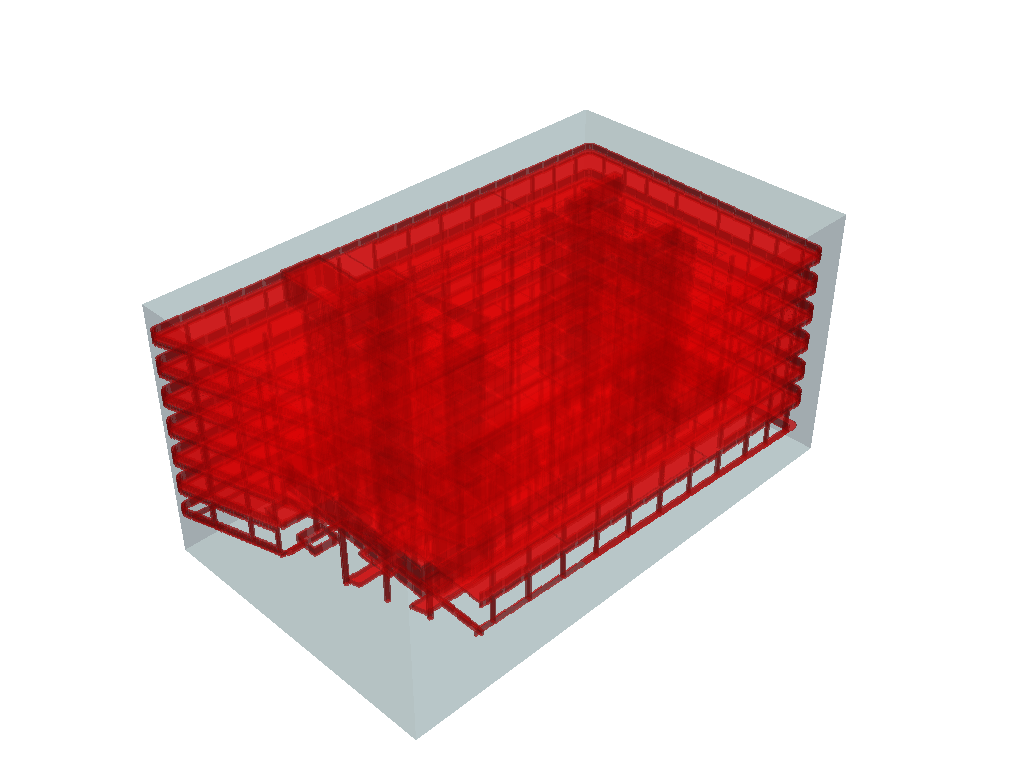

Time taken to visualize: 8.8529 seconds


In [ ]:

### VISUALIZATION ###
start_time = time.time()
p = pv.Plotter()
p.add_mesh(pcd_pv, color="blue", point_size=10.0, render_points_as_spheres=True)
#p.add_mesh(empty_grid, opacity=0.3, show_edges=False)
p.add_mesh(combined_grid.extract_cells(combined_grid.cell_data['values']), color="red", opacity=0.6, show_edges=False)
p.show()
end_time = time.time()
visualization_time = end_time - start_time
print(f"Time taken to visualize: {visualization_time:.4f} seconds")

In [ ]:
### FETCHING CONCRETE ELEMENTS ###
def fetch_concrete_elements(ifc_file):
    concrete_elements = []
    elements = ifc_file.by_type("IfcBuildingElement")
    for element in elements:
        if "concrete" in element.ObjectType.lower():
            if element.GlobalId not in concrete_elements:
                concrete_elements.append(element.GlobalId)
        if "STB" in element.Name:
            if element.GlobalId not in concrete_elements:
                concrete_elements.append(element.GlobalId)

    return concrete_elements

concrete_elements = fetch_concrete_elements(ifc_file)
total_count = 0

for element in concrete_elements:
     
    matching_cells = np.where(grid.cell_data['attributes'] == element)[0]
    
    # Count the number of matching cells
    total_count += len(matching_cells)
    
concrete_volume = round(total_count*voxel_size*voxel_size*voxel_size,3)
print(f'Total concrete volume is {concrete_volume} m3')

KeyboardInterrupt: 

In [ ]:
import pandas as pd

results = {}  # Dictionary to store the results for each IFC file

# Store the results in the dictionary
results['File'] = file_name
results['Conversion Time'] = conversion_time
results['Total Polygons'] = total_polygons
results['Voxel Size'] = voxel_size
results['Total Points'] = sampling_points
results['Point Cloud Creation Time'] = point_cloud_processing
results['Rasterization Time'] = rasterization_time
results['Visualization Time'] = visualization_time
results['Concrete Volume'] = concrete_volume

df = pd.DataFrame([results])

df.to_excel("performance_results.xlsx", index=False)
